*importing libraries and data*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:

pizza_df=pd.read_csv('Pizza_Sale.csv')
ingredient_df=pd.read_csv('Pizza_ingredients.csv')

In [3]:
def date_format(date):
  for format in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=format)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')

In [4]:
df = pd.read_csv('Pizza_Sale_Cleaned.csv') #data cleaned with null values and outliers removed and date formatted   
df['order_date'] = pd.to_datetime(df['order_date'])
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48554 entries, 0 to 48553
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48554 non-null  int64         
 1   order_id           48554 non-null  int64         
 2   pizza_name_id      48554 non-null  object        
 3   quantity           48554 non-null  int64         
 4   order_date         48554 non-null  datetime64[ns]
 5   order_time         48554 non-null  object        
 6   unit_price         48554 non-null  float64       
 7   total_price        48554 non-null  float64       
 8   pizza_size         48554 non-null  object        
 9   pizza_category     48554 non-null  object        
 10  pizza_ingredients  48554 non-null  object        
 11  pizza_name         48554 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 4.4+ MB


Feature selecting and data type cheking

In [5]:
# **Sales details**

df= pd.read_csv('Pizza_Sale_Cleaned.csv')
sales_df = df[['pizza_name','order_date','quantity']]
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'])
sales_df = sales_df.loc[:, ~sales_df.columns.duplicated()]
sales_df.head()


,pizza_name,order_date,quantity
0,The Hawaiian Pizza,2015-01-01,1
1,The Classic Deluxe Pizza,2015-01-01,1
2,The Five Cheese Pizza,2015-01-01,1
3,The Italian Supreme Pizza,2015-01-01,1
4,The Mexicana Pizza,2015-01-01,1


In [6]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48554 entries, 0 to 48553
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   pizza_name  48554 non-null  object        
 1   order_date  48554 non-null  datetime64[ns]
 2   quantity    48554 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
sales_df.isna().sum()

pizza_name    0
order_date    0
quantity      0
dtype: int64

*Data Visualization*

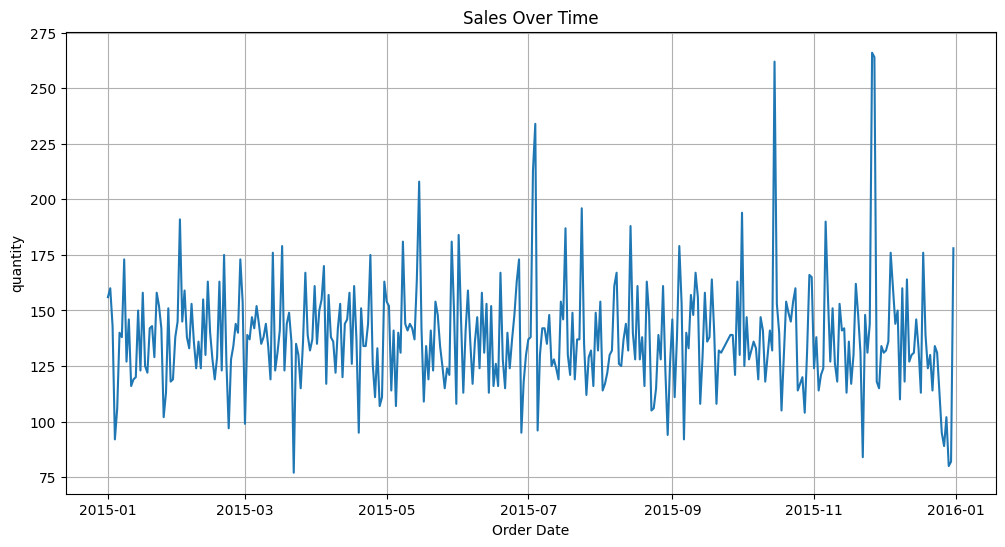

In [8]:
#Sales over time

sales_over_time = sales_df.groupby('order_date')['quantity'].sum()

#plotting sales over time
plt.figure(figsize=(12, 6))
plt.plot(sales_over_time.index, sales_over_time.values)
plt.title('Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('quantity')
plt.grid((True))
plt.show()

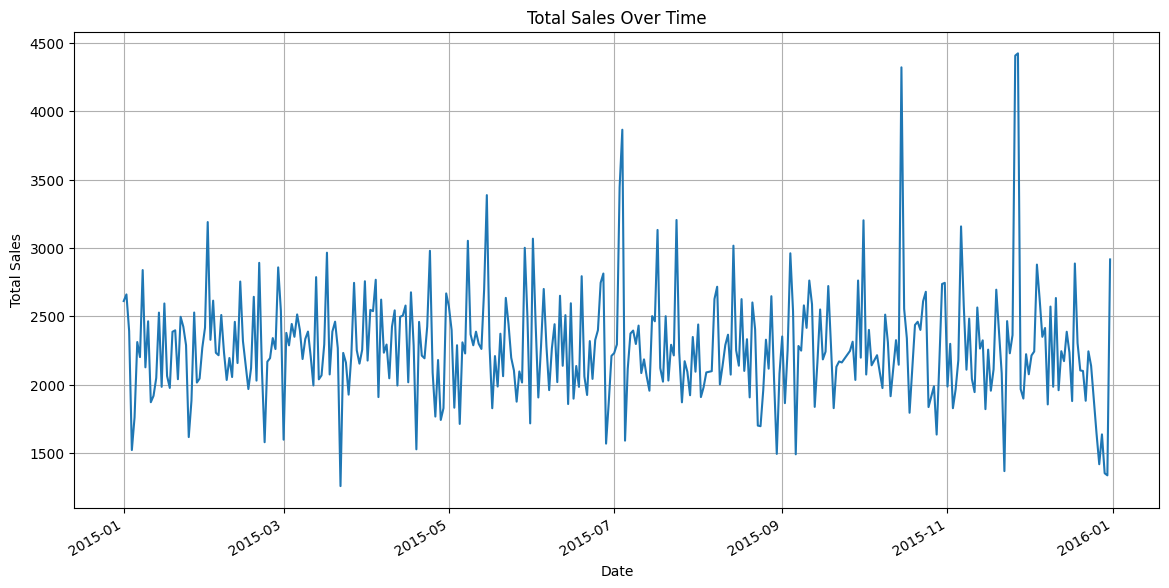

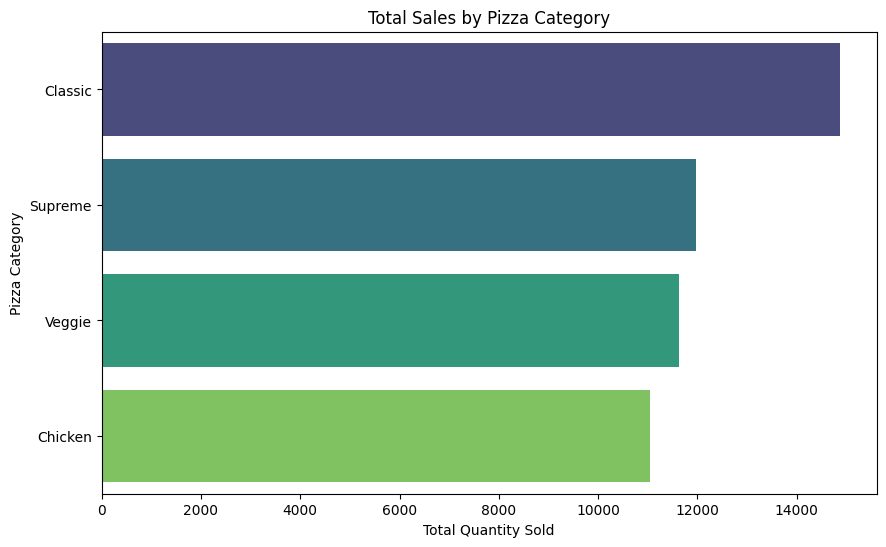

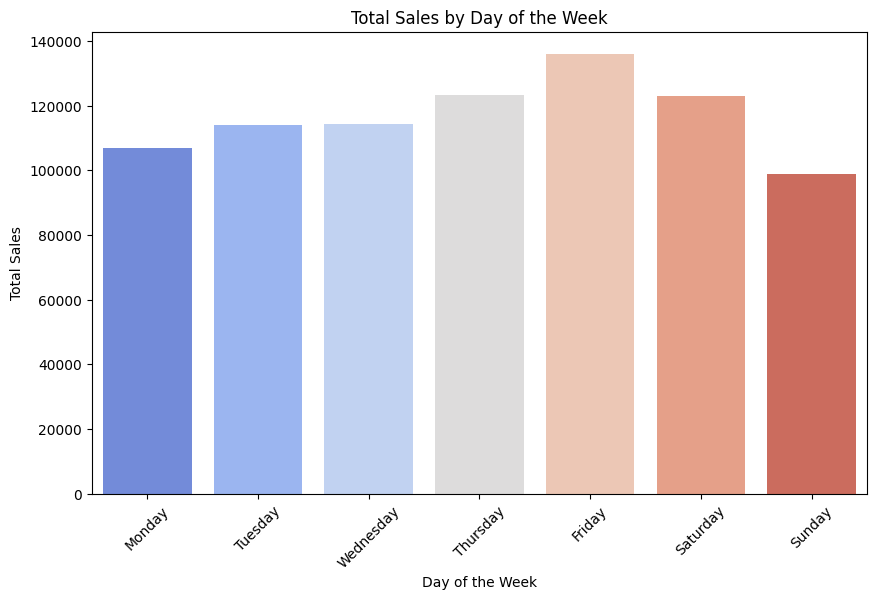

In [9]:
# Ensure 'order_date' is in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Add new features if needed
df['day_of_week'] = df['order_date'].dt.day_name()
df['month'] = df['order_date'].dt.month_name()

# Analyzing overall sales trend over time
plt.figure(figsize=(14, 7))
sales_over_time = df.groupby('order_date')['total_price'].sum()
sales_over_time.plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid()
plt.show()

# Analyzing pizza sales by category
sales_by_category = df.groupby('pizza_category')['quantity'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_category.values, y=sales_by_category.index, palette='viridis')
plt.title('Total Sales by Pizza Category')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Pizza Category')
plt.show()

# Analyzing sales by day of the week
sales_by_day = df.groupby('day_of_week')['total_price'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values, palette='coolwarm')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

*Stationarity Check*

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print("ADF Test Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("\nThe series is stationary (reject the null hypothesis).")
    else:
        print("\nThe series is not stationary (fail to reject the null hypothesis).")

print("Augmented Dickey-Fuller Test Results:")
adf_test(sales_over_time)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -4.232105328470787
p-value: 0.0005811269319562645
Critical Values:
   1%: -3.4497304638968043
   5%: -2.8700785273763487
   10%: -2.571319005190311

The series is stationary (reject the null hypothesis).


In [11]:
sales_df = sales_df.groupby(["order_date", "pizza_name"])['quantity'].sum().unstack().fillna(0)
sales_df.head(5)

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,8.0,8.0,0.0,0.0,5.0,1.0,2.0,6.0,6.0,3.0,...,4.0,6.0,4.0,6.0,11.0,2.0,7.0,4.0,9.0,5.0
2015-01-03,7.0,8.0,0.0,1.0,11.0,5.0,3.0,5.0,4.0,7.0,...,7.0,6.0,1.0,5.0,4.0,3.0,2.0,2.0,9.0,7.0
2015-01-04,9.0,0.0,2.0,2.0,5.0,4.0,1.0,4.0,2.0,4.0,...,4.0,3.0,0.0,1.0,4.0,3.0,4.0,3.0,5.0,1.0
2015-01-05,2.0,3.0,2.0,0.0,6.0,8.0,2.0,9.0,5.0,4.0,...,2.0,5.0,2.0,3.0,2.0,4.0,2.0,2.0,6.0,2.0


In [12]:
sale_data = pizza_df.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)
sale_data.head(5)

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
1/1/2015,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,7.0,6.0,...,4.0,4.0,1.0,7.0,5.0,2.0,5.0,2.0,8.0,3.0
1/10/2015,9.0,1.0,0.0,7.0,8.0,5.0,1.0,11.0,3.0,7.0,...,4.0,16.0,3.0,5.0,6.0,3.0,1.0,7.0,7.0,2.0
1/11/2015,5.0,5.0,0.0,3.0,4.0,4.0,3.0,8.0,5.0,4.0,...,4.0,5.0,0.0,5.0,4.0,3.0,3.0,3.0,7.0,6.0
1/12/2015,6.0,4.0,0.0,2.0,6.0,1.0,5.0,4.0,4.0,7.0,...,4.0,4.0,3.0,5.0,5.0,3.0,1.0,2.0,5.0,3.0
1/2/2015,12.0,9.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0


*Modeling ARIMA with one Pizza*

In [47]:
one_piza = sale_data['The Barbecue Chicken Pizza'].squeeze()  # Ensure Series format

# Splitting data
split_index = int(len(one_piza) * 0.8)
train = one_piza[:split_index]
test = one_piza[split_index:]

# Fit the model
model = ARIMA(train, order=(1,1,1))  # Adjust seasonal_period to match cycle
result = model.fit()

# Forecasting
ari_forecast = result.get_forecast(steps=len(test))
ari_forecast_values = ari_forecast.predicted_mean

# Prediction
ari_pred = result.predict(start=len(train), end=len(train) +len(test) -1, dynamic = True)

ari_pred.index = test.index



            Actual  Predicted
order_date                   
31-12-2015    10.0   6.731943
4/1/2015      11.0   6.755653
4/10/2015     10.0   6.756422
4/11/2015      3.0   6.756446
4/12/2015      8.0   6.756447
...            ...        ...
9/5/2015      10.0   6.756447
9/6/2015       8.0   6.756447
9/7/2015       8.0   6.756447
9/8/2015       6.0   6.756447
9/9/2015       3.0   6.756447

[72 rows x 2 columns]


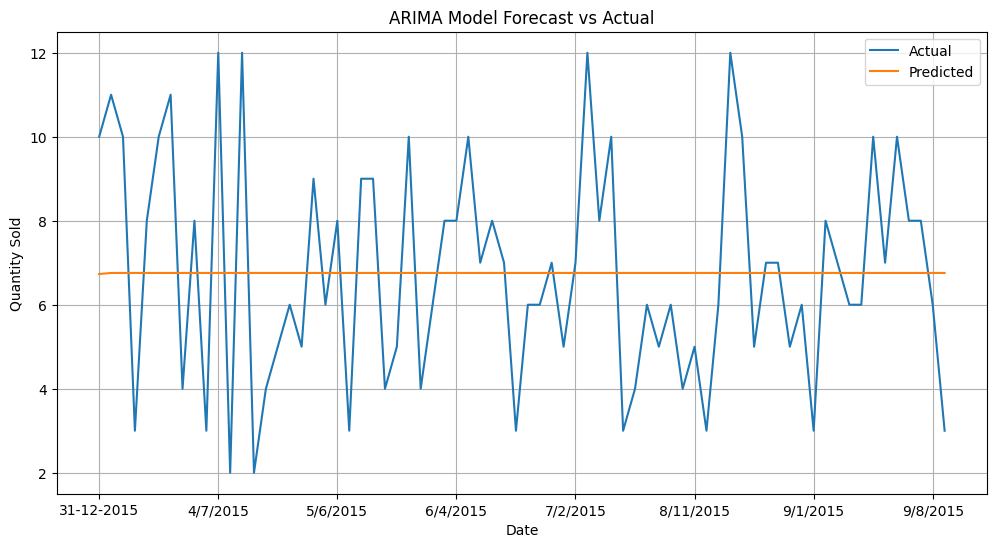

In [48]:
check_series = pd.concat([test, ari_pred], axis=1)
check_series.columns = ['Actual', 'Predicted']
print(check_series)

# Plotting
check_series.plot(figsize=(12,6))
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend(['Actual', 'Predicted'])
plt.grid(True)
plt.show()

In [49]:
mae = mean_absolute_error(test, ari_forecast_values)
mse = mean_squared_error(test, ari_forecast_values)
rmse = np.sqrt(mse)

print(f'ARIMA MAE: {mae}')
print(f'ARIMA MSE: {mse}')
print(f'ARIMA RMSE: {rmse}')

ARIMA MAE: 2.2086850403678633
ARIMA MSE: 7.043841088794263
ARIMA RMSE: 2.6540235659832154


*Modeling with SARIMAX*

In [ ]:
one_piza = sale_data['The Barbecue Chicken Pizza'].squeeze()  # Ensure Series format

# Splitting data
split_index = int(len(one_piza) * 0.8)
train = one_piza[:split_index]
test = one_piza[split_index:]

# Fit the model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,30))  # Adjust seasonal_period to match cycle
result = model.fit()

# Forecasting
ari_forecast = result.get_forecast(steps=len(test))
forecast_values = ari_forecast.predicted_mean

# Prediction
ari_pred = result.predict(start=len(train), end=len(train) +len(test) -1, dynamic = True)

ari_pred.index = test.index



            Actual  Predicted
order_date                   
31-12-2015    10.0   5.968917
4/1/2015      11.0   6.400550
4/10/2015     10.0   3.940022
4/11/2015      3.0   5.047706
4/12/2015      8.0   6.634762
...            ...        ...
9/5/2015      10.0   6.112426
9/6/2015       8.0   5.833980
9/7/2015       8.0   5.298574
9/8/2015       6.0   6.523598
9/9/2015       3.0   7.454415

[72 rows x 2 columns]


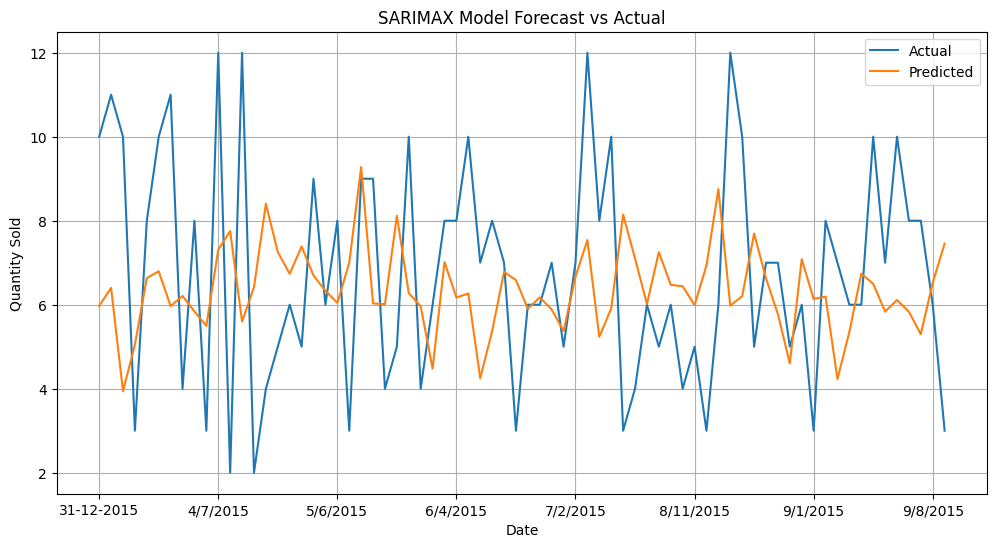

In [43]:
check_series = pd.concat([test, ari_pred], axis=1)
check_series.columns = ['Actual', 'Predicted']
print(check_series)

# Plotting
check_series.plot(figsize=(12,6))
plt.title('SARIMAX Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend(['Actual', 'Predicted'])
plt.grid(True)
plt.show()

In [46]:
mae = mean_absolute_error(test, forecast_values)
mse = mean_squared_error(test, forecast_values)
rmse = np.sqrt(mse)

print(f'SARIMA MAE: {mae}')
print(f'SARIMA MSE: {mse}')
print(f'SARIMA RMSE: {rmse}')

SARIMA MAE: 2.524509566085681
SARIMA MSE: 9.057096674761379
SARIMA RMSE: 3.009501067413231


*Prediction and Purchasing Order*

In [2]:
pizza_df = pd.read_csv('Pizza_Sale_Cleaned.csv')
pizza_df = pizza_df[['order_date', 'pizza_name', 'quantity']]
pizza_df.head(5)

,order_date,pizza_name,quantity
0,2015-01-01,The Hawaiian Pizza,1
1,2015-01-01,The Classic Deluxe Pizza,1
2,2015-01-01,The Five Cheese Pizza,1
3,2015-01-01,The Italian Supreme Pizza,1
4,2015-01-01,The Mexicana Pizza,1


In [ ]:
sales_report = pizza_df.groupby(['order_date', 'pizza_name']).sum().reset_index()
print(sales_report.head(5))
sales_report.isna().sum()

  order_date                    pizza_name  quantity  log_quantity
0 2015-01-01    The Barbecue Chicken Pizza        11      2.484907
1 2015-01-01            The Big Meat Pizza         5      1.791759
2 2015-01-01           The Calabrese Pizza         1      0.693147
3 2015-01-01  The California Chicken Pizza         4      1.609438
4 2015-01-01     The Chicken Alfredo Pizza         2      1.098612


order_date      0
pizza_name      0
quantity        0
log_quantity    0
dtype: int64

In [22]:
sales_pivot = sales_report.pivot(index='order_date', columns='pizza_name', values='quantity').fillna(0) #reshape the data
sales_pivot.index = pd.to_datetime(sales_pivot.index) #date and time format
sales_pivot = sales_pivot.asfreq('W') #change frequency to weekly
sales_pivot.head(5)

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-04,9.0,0.0,2.0,2.0,5.0,4.0,1.0,4.0,2.0,4.0,...,4.0,3.0,0.0,1.0,4.0,3.0,4.0,3.0,5.0,1.0
2015-01-11,6.0,3.0,1.0,4.0,5.0,1.0,5.0,3.0,0.0,3.0,...,3.0,6.0,3.0,1.0,4.0,2.0,0.0,5.0,4.0,4.0
2015-01-18,9.0,4.0,0.0,1.0,9.0,1.0,2.0,7.0,3.0,5.0,...,4.0,7.0,3.0,2.0,3.0,3.0,3.0,3.0,5.0,2.0
2015-01-25,8.0,6.0,3.0,3.0,3.0,2.0,1.0,2.0,1.0,6.0,...,6.0,3.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0,4.0
2015-02-01,12.0,9.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0


In [65]:
arima_model = {}

for pizza_name in sales_pivot.columns:
    try:
        model = ARIMA(sales_pivot[pizza_name], order=(1, 1, 1))
        model_fit = model.fit()
        arima_model[pizza_name] = model_fit
        print(f"ARIMA model for {pizza_name} fitted successfully.")
    except Exception as e:
        print(f"Error fitting ARIMA model for {pizza_name}: {e}")
        

ARIMA model for The Barbecue Chicken Pizza fitted successfully.
ARIMA model for The Big Meat Pizza fitted successfully.
ARIMA model for The Brie Carre Pizza fitted successfully.
ARIMA model for The Calabrese Pizza fitted successfully.
ARIMA model for The California Chicken Pizza fitted successfully.
ARIMA model for The Chicken Alfredo Pizza fitted successfully.
ARIMA model for The Chicken Pesto Pizza fitted successfully.
ARIMA model for The Classic Deluxe Pizza fitted successfully.
ARIMA model for The Five Cheese Pizza fitted successfully.
ARIMA model for The Four Cheese Pizza fitted successfully.
ARIMA model for The Greek Pizza fitted successfully.
ARIMA model for The Green Garden Pizza fitted successfully.
ARIMA model for The Hawaiian Pizza fitted successfully.
ARIMA model for The Italian Capocollo Pizza fitted successfully.
ARIMA model for The Italian Supreme Pizza fitted successfully.
ARIMA model for The Italian Vegetables Pizza fitted successfully.
ARIMA model for The Mediterranea

*Prediction for one week*

In [66]:
prediction_days = 7
prediction_arima = {}

for pizza_name, model in arima_model.items():
    prediction_arima[pizza_name] = model.predict(start=len(sales_pivot),end=len(sales_pivot) + prediction_days - 1)

In [67]:
prediction_df = pd.DataFrame(prediction_arima)
prediction_df.index = pd.date_range(start=sales_pivot.index[-1], periods=prediction_days, freq='D')
prediction_df.head(5)


,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2015-12-27,5.903727,4.959616,1.626924,2.480494,5.656436,2.084186,2.293939,5.058502,3.110280,4.201982,...,3.162904,4.759480,2.032581,3.901828,3.355489,2.460540,2.392819,3.077304,5.441595,4.778467
2015-12-28,5.723469,4.958233,1.524212,2.213684,5.596189,2.169204,2.427620,5.351030,3.096487,4.141142,...,3.343517,4.884231,2.149244,4.233874,3.355673,2.382632,2.156226,3.453741,5.422983,5.917770
2015-12-29,5.740537,4.958185,1.541040,2.261768,5.597556,2.172672,2.402310,5.321938,3.096658,4.159468,...,3.358599,4.904722,2.162425,4.291847,3.355673,2.371381,2.196415,3.521957,5.423767,5.610296
2015-12-30,5.738921,4.958184,1.538283,2.253102,5.597525,2.172814,2.407102,5.324831,3.096656,4.153948,...,3.359859,4.908088,2.163914,4.301969,3.355673,2.369756,2.189589,3.534319,5.423734,5.693277
2015-12-31,5.739074,4.958183,1.538734,2.254664,5.597525,2.172819,2.406195,5.324544,3.096656,4.155611,...,3.359964,4.908641,2.164082,4.303736,3.355673,2.369521,2.190748,3.536559,5.423736,5.670882


In [68]:
ingredient_df = pd.read_csv('Pizza_ingredients.csv')
ingredient_df = ingredient_df[['pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams']]
ingredient_df.head(5)

,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,The Barbecue Chicken Pizza,Red Peppers,15.0
2,The Barbecue Chicken Pizza,Green Peppers,20.0
3,The Barbecue Chicken Pizza,Tomatoes,30.0
4,The Barbecue Chicken Pizza,Red Onions,60.0


In [69]:
required_ingredients = {}

for pizza_name in prediction_df.columns:
    predicted_quantity = prediction_df[pizza_name].sum()
    pizza_ingredients = ingredient_df[ingredient_df['pizza_name'] == pizza_name]

    for index, row in pizza_ingredients.iterrows():
        ingredient = row['pizza_ingredients']
        quantity_per_pizza = row['Items_Qty_In_Grams']
        total_quantity = predicted_quantity * quantity_per_pizza

        if ingredient in required_ingredients:
            required_ingredients[ingredient] += total_quantity
        else:
            required_ingredients[ingredient] = total_quantity

In [70]:
# Convert the required_ingredients dictionary to a DataFrame
purchase_order = pd.DataFrame(list(required_ingredients.items()), columns=['Ingredient', 'Required_Quantity'])
purchase_order['Required_Quantity'] = purchase_order['Required_Quantity'].round(2)

purchase_order['Units'] = 'Grams' # Add a column for the unit of measurement

# Sort and reset index
purchase_order.sort_values(by='Required_Quantity', ascending=False, inplace=True)
purchase_order.reset_index(drop=True, inplace=True)

print(purchase_order.to_string())

                    Ingredient  Required_Quantity  Units
0                   Red Onions           44297.14  Grams
1                      Chicken           41619.65  Grams
2                    Capocollo           31295.31  Grams
3                     Tomatoes           29301.30  Grams
4                    Mushrooms           19814.57  Grams
5                    Pepperoni           18088.11  Grams
6                      Spinach           16482.20  Grams
7                        Bacon           15204.41  Grams
8                       Garlic           14367.13  Grams
9             Beef Chuck Roast           13072.21  Grams
10                        Corn           10738.39  Grams
11            Calabrese Salami            9651.43  Grams
12                 Feta Cheese            8730.67  Grams
13           Mozzarella Cheese            8662.63  Grams
14                 Red Peppers            8375.82  Grams
15      Coarse Sicilian Salami            8203.83  Grams
16                   Pineapple 

In [71]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE for each pizza
mape_results = {}

for pizza_name, model in arima_model.items():
    actual = sales_pivot[pizza_name][-len(prediction_arima[pizza_name]):]  # Actual values
    predicted = prediction_arima[pizza_name]  # Predicted values
    mape = mean_absolute_percentage_error(actual, predicted)
    mape_results[pizza_name] = mape

# Display MAPE results
for pizza_name, mape in mape_results.items():
    print(f"{pizza_name}: MAPE = {mape:.2%}")

The Barbecue Chicken Pizza: MAPE = 32.51%
The Big Meat Pizza: MAPE = 31.20%
The Brie Carre Pizza: MAPE = 197056428579629824.00%
The Calabrese Pizza: MAPE = 145515660551817824.00%
The California Chicken Pizza: MAPE = 71.13%
The Chicken Alfredo Pizza: MAPE = 279353377313611264.00%
The Chicken Pesto Pizza: MAPE = 44.81%
The Classic Deluxe Pizza: MAPE = 29.70%
The Five Cheese Pizza: MAPE = 199229970869268288.00%
The Four Cheese Pizza: MAPE = 92.85%
The Greek Pizza: MAPE = 49.00%
The Green Garden Pizza: MAPE = 312718598805810176.00%
The Hawaiian Pizza: MAPE = 23.05%
The Italian Capocollo Pizza: MAPE = 32.49%
The Italian Supreme Pizza: MAPE = 60.50%
The Italian Vegetables Pizza: MAPE = 437524209116235840.00%
The Mediterranean Pizza: MAPE = 260598618293645760.00%
The Mexicana Pizza: MAPE = 63.43%
The Napolitana Pizza: MAPE = 34.75%
The Pepper Salami Pizza: MAPE = 37.89%
The Pepperoni Pizza: MAPE = 86.67%
The Pepperoni, Mushroom, and Peppers Pizza: MAPE = 47.25%
The Prosciutto and Arugula Pizz

In [72]:
sarimax_model = {}

for pizza_name in sales_pivot.columns:
    try:
        model = SARIMAX(sales_pivot[pizza_name], order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
        model_fit = model.fit()
        sarimax_model[pizza_name] = model_fit
        print(f"SARIMAX model for {pizza_name} fitted successfully.")
    except Exception as e:
        print(f"Error fitting SARIMAX model for {pizza_name}: {e}")
        

SARIMAX model for The Barbecue Chicken Pizza fitted successfully.
SARIMAX model for The Big Meat Pizza fitted successfully.
SARIMAX model for The Brie Carre Pizza fitted successfully.
SARIMAX model for The Calabrese Pizza fitted successfully.
SARIMAX model for The California Chicken Pizza fitted successfully.
SARIMAX model for The Chicken Alfredo Pizza fitted successfully.
SARIMAX model for The Chicken Pesto Pizza fitted successfully.
SARIMAX model for The Classic Deluxe Pizza fitted successfully.
SARIMAX model for The Five Cheese Pizza fitted successfully.
SARIMAX model for The Four Cheese Pizza fitted successfully.
SARIMAX model for The Greek Pizza fitted successfully.
SARIMAX model for The Green Garden Pizza fitted successfully.
SARIMAX model for The Hawaiian Pizza fitted successfully.
SARIMAX model for The Italian Capocollo Pizza fitted successfully.
SARIMAX model for The Italian Supreme Pizza fitted successfully.
SARIMAX model for The Italian Vegetables Pizza fitted successfully.


In [73]:
prediction_days = 7
prediction_sarimax = {}

for pizza_name, model in sarimax_model.items():
    prediction_sarimax[pizza_name] = model.predict(start=len(sales_pivot),end=len(sales_pivot) + prediction_days - 1)

In [74]:
prediction_df = pd.DataFrame(prediction_sarimax)
prediction_df.index = pd.date_range(start=sales_pivot.index[-1], periods=prediction_days, freq='D')
prediction_df.head(5)


,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2015-12-27,3.822194,6.511918,1.774450,1.917107,6.695150,1.076295,5.282404,-0.023365,6.639267,-0.441315,...,4.586682,3.373467,1.134830,4.438616,5.704811,4.506318,1.056640,0.086361,4.114840,3.055447
2015-12-28,9.807359,2.268054,-0.056030,0.773591,3.638661,0.190393,0.401406,6.014580,4.766129,7.265710,...,5.048145,2.448003,2.696977,0.475794,3.726411,2.144979,8.270765,-0.098972,5.087171,8.556630
2015-12-29,1.806121,6.384226,0.920522,3.780640,5.627912,4.202476,3.381671,3.325654,2.754309,1.918930,...,3.094578,4.462870,1.527549,3.788609,3.726182,1.057570,2.222179,2.932648,3.093861,6.655791
2015-12-30,5.806018,3.328880,-0.076235,3.780297,4.625081,0.203777,1.384944,3.556884,2.755415,1.088927,...,1.099258,2.465822,0.578619,2.882879,1.726210,2.036438,3.233142,1.927200,5.092215,7.980245
2015-12-31,3.806009,2.355256,1.923316,2.780317,2.619914,0.203979,1.384401,2.484181,2.755206,1.005777,...,0.099787,12.466270,0.563208,1.911036,1.726237,2.031381,1.230936,1.928473,7.092711,7.863380


In [75]:
ingredient_df = pd.read_csv('Pizza_ingredients.csv')
ingredient_df = ingredient_df[['pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams']]
ingredient_df.head(5)

,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,The Barbecue Chicken Pizza,Red Peppers,15.0
2,The Barbecue Chicken Pizza,Green Peppers,20.0
3,The Barbecue Chicken Pizza,Tomatoes,30.0
4,The Barbecue Chicken Pizza,Red Onions,60.0


In [76]:
required_ingredients = {}

for pizza_name in prediction_df.columns:
    predicted_quantity = prediction_df[pizza_name].sum()
    pizza_ingredients = ingredient_df[ingredient_df['pizza_name'] == pizza_name]

    for index, row in pizza_ingredients.iterrows():
        ingredient = row['pizza_ingredients']
        quantity_per_pizza = row['Items_Qty_In_Grams']
        total_quantity = predicted_quantity * quantity_per_pizza

        if ingredient in required_ingredients:
            required_ingredients[ingredient] += total_quantity
        else:
            required_ingredients[ingredient] = total_quantity

In [77]:
# Convert the required_ingredients dictionary to a DataFrame
purchase_order = pd.DataFrame(list(required_ingredients.items()), columns=['Ingredient', 'Required_Quantity'])
purchase_order['Required_Quantity'] = purchase_order['Required_Quantity'].round(2)

purchase_order['Units'] = 'Grams' # Add a column for the unit of measurement

# Sort and reset index
purchase_order.sort_values(by='Required_Quantity', ascending=False, inplace=True)
purchase_order.reset_index(drop=True, inplace=True)

print(purchase_order.to_string())

                    Ingredient  Required_Quantity  Units
0                   Red Onions           41799.84  Grams
1                    Capocollo           38313.82  Grams
2                      Chicken           34544.79  Grams
3                     Tomatoes           30897.50  Grams
4             Beef Chuck Roast           18671.03  Grams
5                    Pepperoni           18638.05  Grams
6                    Mushrooms           16160.25  Grams
7                      Spinach           15314.19  Grams
8                       Garlic           14981.43  Grams
9                        Bacon           12035.69  Grams
10      Coarse Sicilian Salami            9394.75  Grams
11                 Feta Cheese            9194.13  Grams
12                 Goat Cheese            8309.13  Grams
13                 Red Peppers            8040.95  Grams
14                        Corn            7744.11  Grams
15            Calabrese Salami            7466.48  Grams
16           Mozzarella Cheese 

In [78]:
# Calculate MAPE for each pizza
mape_results = {}

for pizza_name, model in sarimax_model.items():
    actual = sales_pivot[pizza_name][-len(prediction_sarimax[pizza_name]):]  # Actual values
    predicted = prediction_sarimax[pizza_name]  # Predicted values
    mape = mean_absolute_percentage_error(actual, predicted)
    mape_results[pizza_name] = mape

# Display MAPE results
for pizza_name, mape in mape_results.items():
    print(f"{pizza_name}: MAPE = {mape:.2%}")

The Barbecue Chicken Pizza: MAPE = 76.74%
The Big Meat Pizza: MAPE = 44.20%
The Brie Carre Pizza: MAPE = 63012518225343640.00%
The Calabrese Pizza: MAPE = 243235567777763904.00%
The California Chicken Pizza: MAPE = 70.48%
The Chicken Alfredo Pizza: MAPE = 218821482811504384.00%
The Chicken Pesto Pizza: MAPE = 66.66%
The Classic Deluxe Pizza: MAPE = 29.42%
The Five Cheese Pizza: MAPE = 177262051647583264.00%
The Four Cheese Pizza: MAPE = 153.57%
The Greek Pizza: MAPE = 95.82%
The Green Garden Pizza: MAPE = 144749266733247616.00%
The Hawaiian Pizza: MAPE = 42.69%
The Italian Capocollo Pizza: MAPE = 65.11%
The Italian Supreme Pizza: MAPE = 76.82%
The Italian Vegetables Pizza: MAPE = 495307539135946880.00%
The Mediterranean Pizza: MAPE = 248150263350507648.00%
The Mexicana Pizza: MAPE = 66.07%
The Napolitana Pizza: MAPE = 48.44%
The Pepper Salami Pizza: MAPE = 79.98%
The Pepperoni Pizza: MAPE = 104.47%
The Pepperoni, Mushroom, and Peppers Pizza: MAPE = 78.61%
The Prosciutto and Arugula Piz